In [497]:
import sklearn.preprocessing
import tensorboard
import tensorflow as tf
from packaging import version
from datetime import datetime
import numpy as np
from linkmethods import get_target, get_backlink_views
from keras.layers import *

In [498]:
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.11.0


In [499]:
tensorboard.__version__

'2.11.0'

In [500]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [501]:
article = "Meisen"

In [502]:
df_main = get_target(article)

In [503]:
bl_views = get_backlink_views(article, get_target(article))

            views
timestamp        
2015070100    2.0
2015070200    0.0
2015070300    4.0
2015070400    4.0
2015070500    1.0
...           ...
2022062700    1.0
2022062800    3.0
2022062900    1.0
2022063000    0.0
2022070100    3.0

[2558 rows x 1 columns]
            views
timestamp        
2015070100    7.0
2015070200   10.0
2015070300    6.0
2015070400    7.0
2015070500   11.0
...           ...
2022062700    5.0
2022062800    9.0
2022062900   11.0
2022063000   14.0
2022070100    9.0

[2558 rows x 1 columns]
            views
timestamp        
2015070100   1678
2015070200   1719
2015070300   1764
2015070400   1876
2015070500   2426
...           ...
2022062700   2452
2022062800   2906
2022062900   2974
2022063000   2838
2022070100   1921

[2558 rows x 1 columns]
            views
timestamp        
2015070100    0.0
2015070200    0.0
2015070300    0.0
2015070400    0.0
2015070500    0.0
...           ...
2022062700    0.0
2022062800    0.0
2022062900    2.0
2022063000    1.0
2022070

In [504]:
roundoff = 10

In [505]:
roundeddata = []
for entry in bl_views:
    roundeddata.append((entry[:]//roundoff*roundoff)[-250:-1])
np.shape(roundeddata)

(162, 249)

In [506]:
roundeddata = np.array(roundeddata)

In [507]:
data = np.array(bl_views)[:,-250:-1]
print(data)
data.shape

[[0.000e+00 4.000e+00 3.000e+00 ... 3.000e+00 1.000e+00 0.000e+00]
 [8.000e+00 1.300e+01 1.300e+01 ... 9.000e+00 1.100e+01 1.400e+01]
 [4.460e+02 4.130e+02 3.860e+02 ... 2.906e+03 2.974e+03 2.838e+03]
 ...
 [6.400e+01 6.400e+01 6.700e+01 ... 9.300e+01 9.800e+01 8.000e+01]
 [3.690e+02 3.980e+02 4.080e+02 ... 1.920e+02 1.630e+02 1.350e+02]
 [1.000e+00 1.000e+00 1.000e+00 ... 1.000e+00 1.000e+00 1.000e+00]]


(162, 249)

In [508]:
target = np.array(df_main.views)[-250:-1]
target = np.array([np.copy(target) for _ in range((data.shape[0]))])
print(target)
target.shape

[[275 281 269 ... 192 190 180]
 [275 281 269 ... 192 190 180]
 [275 281 269 ... 192 190 180]
 ...
 [275 281 269 ... 192 190 180]
 [275 281 269 ... 192 190 180]
 [275 281 269 ... 192 190 180]]


(162, 249)

In [509]:
roundedtarget = target//roundoff*roundoff
np.shape(roundedtarget)

(162, 249)

In [510]:
roundedtarget = np.array(roundedtarget)

In [535]:
import keras.backend

In [536]:
def round_activation(x):
  return tf.keras.backend.round(x/10)*10

In [537]:
# Define the model.
model = keras.Sequential()

# 1 dense hidden layer with 250 nodes ~90+ acc
model.add(Input(shape=249)) # Input tensor
model.add(Dense(units=249)) # hidden layer 1,
model.add(Activation(activation="sigmoid"))

model.compile(
    optimizer='Adam',
    loss='mean_squared_error',
    metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 249)               62250     
                                                                 
 activation_20 (Activation)  (None, 249)               0         
                                                                 
Total params: 62,250
Trainable params: 62,250
Non-trainable params: 0
_________________________________________________________________


In [538]:
roundeddata = (roundeddata-roundeddata.mean())/roundeddata.std()
roundedtarget = (roundedtarget-roundedtarget.mean())/roundedtarget.std()

In [539]:
roundeddata

array([[-0.1224281 , -0.1224281 , -0.1224281 , ..., -0.1224281 ,
        -0.1224281 , -0.1224281 ],
       [-0.1224281 , -0.11526724, -0.11526724, ..., -0.1224281 ,
        -0.11526724, -0.11526724],
       [ 0.19264949,  0.17116693,  0.14968436, ...,  1.95421963,
         2.00434561,  1.90409365],
       ...,
       [-0.07946297, -0.07946297, -0.07946297, ..., -0.05798041,
        -0.05798041, -0.06514126],
       [ 0.13536266,  0.15684522,  0.16400607, ...,  0.01362813,
        -0.00785443, -0.02933699],
       [-0.1224281 , -0.1224281 , -0.1224281 , ..., -0.1224281 ,
        -0.1224281 , -0.1224281 ]])

In [540]:
predata = sklearn.preprocessing.normalize(data,norm="l1")
pretarget = sklearn.preprocessing.normalize(target,norm="l1")
predata

array([[0.        , 0.00727273, 0.00545455, ..., 0.00545455, 0.00181818,
        0.        ],
       [0.00313725, 0.00509804, 0.00509804, ..., 0.00352941, 0.00431373,
        0.0054902 ],
       [0.00104952, 0.00097187, 0.00090833, ..., 0.00683837, 0.00699839,
        0.00667835],
       ...,
       [0.00261684, 0.00261684, 0.0027395 , ..., 0.00380259, 0.00400703,
        0.00327105],
       [0.00532952, 0.00574837, 0.0058928 , ..., 0.00277308, 0.00235423,
        0.00194982],
       [0.00293255, 0.00293255, 0.00293255, ..., 0.00293255, 0.00293255,
        0.00293255]])

In [541]:
from sklearn.model_selection import train_test_split

# Separate the test data
x, x_test, y, y_test = train_test_split(predata, pretarget, test_size=0.15, shuffle=True)

# Split the remaining data to train and validation
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, shuffle=True)

In [542]:
x_train.shape

(116, 249)

In [543]:
y_train.shape

(116, 249)

In [544]:
# Train the model.
early_stop = keras.callbacks.EarlyStopping(monitor="accuracy", patience=50, restore_best_weights=True)
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=1500,
    validation_data=(x_val, y_val))

Epoch 1/1500
4/4 [==============================] - 0s 29ms/step - loss: 0.2456 - accuracy: 0.0000e+00 - val_loss: 0.2444 - val_accuracy: 0.0000e+00
Epoch 2/1500
4/4 [==============================] - 0s 6ms/step - loss: 0.2439 - accuracy: 0.0000e+00 - val_loss: 0.2427 - val_accuracy: 0.0000e+00
Epoch 3/1500
4/4 [==============================] - 0s 7ms/step - loss: 0.2421 - accuracy: 0.0000e+00 - val_loss: 0.2410 - val_accuracy: 0.0000e+00
Epoch 4/1500
4/4 [==============================] - 0s 7ms/step - loss: 0.2404 - accuracy: 0.0000e+00 - val_loss: 0.2392 - val_accuracy: 0.0000e+00
Epoch 5/1500
4/4 [==============================] - 0s 7ms/step - loss: 0.2386 - accuracy: 0.0000e+00 - val_loss: 0.2374 - val_accuracy: 0.0000e+00
Epoch 6/1500
4/4 [==============================] - 0s 9ms/step - loss: 0.2368 - accuracy: 0.0000e+00 - val_loss: 0.2356 - val_accuracy: 0.0000e+00
Epoch 7/1500
4/4 [==============================] - 0s 9ms/step - loss: 0.2350 - accuracy: 0.0000e+00 - val_los

In [545]:
from matplotlib import pyplot as plt
def display_learning_curves(history):
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))

    axs[0,0].plot(history.history["loss"])
    axs[0,0].legend(["train", "test"], loc="upper right")
    axs[0,0].set_xlabel("Epochs")
    axs[0,0].set_ylabel("Loss")

    axs[0,1].plot(history.history["accuracy"])
    axs[0,1].legend(["train", "test"], loc="upper right")
    axs[0,1].set_xlabel("Epochs")
    axs[0,1].set_ylabel("Accuracy")

    axs[1,0].plot(history.history["val_loss"])
    axs[1,0].legend(["train", "test"], loc="upper right")
    axs[1,0].set_xlabel("Epochs")
    axs[1,0].set_ylabel("val_loss")

    axs[1,1].plot(history.history["val_accuracy"])
    axs[1,1].legend(["train", "test"], loc="upper right")
    axs[1,1].set_xlabel("Epochs")
    axs[1,1].set_ylabel("val_Accuracy")
    plt.show()

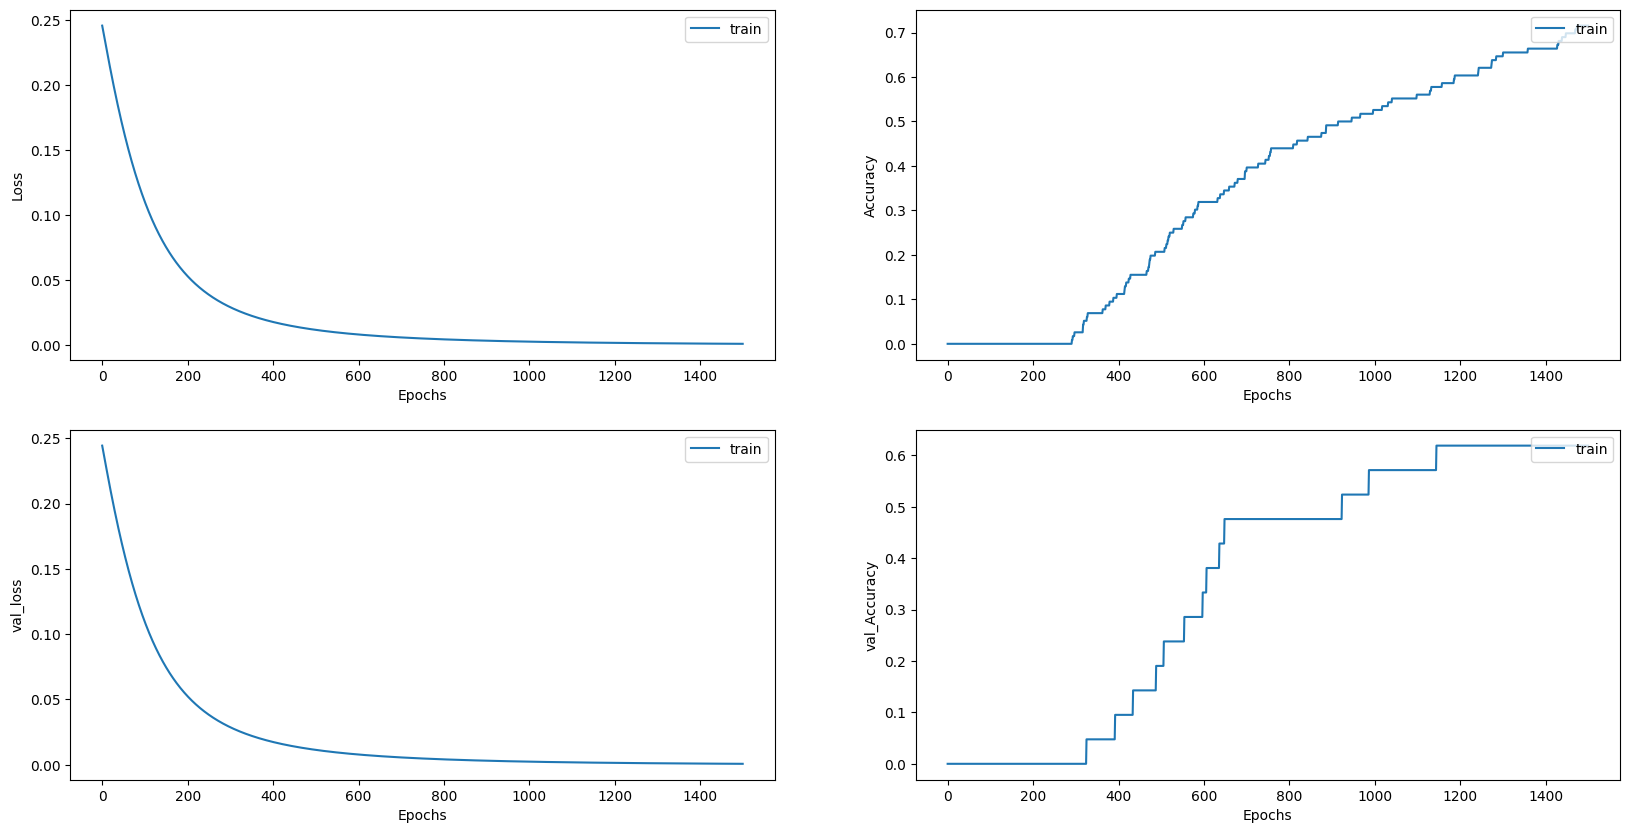

In [546]:
display_learning_curves(history)

In [523]:
%load_ext tensorboard

In [524]:
%tensorboard --logdir logs/fit --host localhost --port 8088

Launching TensorBoard...

In [525]:
inputs = keras.Input(shape=(2558,))

In [526]:
inputs.shape

TensorShape([None, 2558])

In [527]:
dense = Dense(2558, activation="relu")
x = dense(inputs)
outputs = Dense(2558)(x)

In [528]:
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

In [529]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 2558)]            0         
                                                                 
 dense_36 (Dense)            (None, 2558)              6545922   
                                                                 
 dense_37 (Dense)            (None, 2558)              6545922   
                                                                 
Total params: 13,091,844
Trainable params: 13,091,844
Non-trainable params: 0
_________________________________________________________________


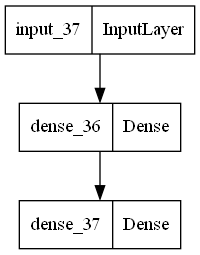

In [530]:
keras.utils.plot_model(model, "my_first_model.png")

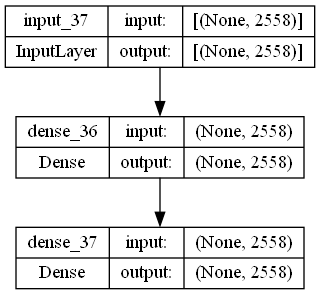

In [531]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

In [532]:
early_stop = keras.callbacks.EarlyStopping(monitor="accuracy", patience=25, restore_best_weights=True)
model.compile(
    loss=keras.losses.MeanAbsoluteError(reduction="auto",name="mean_absolute_error"),
    optimizer=keras.optimizers.Adam(learning_rate=0.02),
    metrics=["accuracy"],
)

history = model.fit(
    data,
    target,
    batch_size=32,
    epochs=150,
    validation_split=0.2,
    callbacks=[tensorboard_callback, early_stop])

Epoch 1/150


ValueError: in user code:

    File "C:\Users\Marvin\PycharmProjects\pythonProject\venv\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Marvin\PycharmProjects\pythonProject\venv\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Marvin\PycharmProjects\pythonProject\venv\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Marvin\PycharmProjects\pythonProject\venv\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Marvin\PycharmProjects\pythonProject\venv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Marvin\PycharmProjects\pythonProject\venv\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "mnist_model" is incompatible with the layer: expected shape=(None, 2558), found shape=(None, 249)


In [ ]:
from matplotlib import pyplot as plt


def display_learning_curves(history):
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))

    axs[0,0].plot(history.history["loss"])
    axs[0,0].legend(["train", "test"], loc="upper right")
    axs[0,0].set_xlabel("Epochs")
    axs[0,0].set_ylabel("Loss")

    axs[0,1].plot(history.history["accuracy"])
    axs[0,1].legend(["train", "test"], loc="upper right")
    axs[0,1].set_xlabel("Epochs")
    axs[0,1].set_ylabel("Accuracy")

    axs[1,0].plot(history.history["val_loss"])
    axs[1,0].legend(["train", "test"], loc="upper right")
    axs[1,0].set_xlabel("Epochs")
    axs[1,0].set_ylabel("val_loss")

    axs[1,1].plot(history.history["val_accuracy"])
    axs[1,1].legend(["train", "test"], loc="upper right")
    axs[1,1].set_xlabel("Epochs")
    axs[1,1].set_ylabel("val_Accuracy")
    plt.show()

In [ ]:
display_learning_curves(history)

In [ ]:
weights = model.get_weights()
weights

In [ ]:
len(weights)